# Post-processing Attractors
(C) 2018 Dariusz Kajtoch

In [55]:
def read_data(filename):
    import numpy as np
    # take width and height from header
    with open(filename, "rb") as f:
        header = f.readline().split()
        (width, height) = [int(x) for x in header]
        f.close()
        
    data = np.memmap(filename, offset=10, dtype='float32', shape=(height,width))
    
    return data

def read_pgm(filename):
    import numpy as np
    # take width, height and max
    with open(filename, "rb") as f:
        header = f.readline().split()
        (width, height, maxval) = [int(header[i]) for i in range(1,4)]
        
    if maxval == 255:
        data = np.memmap(filename, offset=17, dtype='uint8', shape=(height,width))
    else:
        data = np.memmap(filename, offset=19, dtype='uint16', shape=(height,width))
        
    data.astype(np.float32)
    data = data/maxval
        
    return data

In [85]:
data = read_pgm('peterdejong8bit.pgm')

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors
plt.rc('axes.spines', **{'bottom':False, 'left':False, 'right':False, 'top':False})
plt.rc('xtick', labelbottom=False, labeltop=False)
plt.rc('xtick.major', top=False, bottom=False)
plt.rc('ytick', labelleft=False, labelright=False)
plt.rc('ytick.major', left=False, right=False)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['text.usetex']=True

In [83]:
def save_fig(data, name, cmap):
    plt.close()
    fig, ax = plt.subplots()
    
    ax.imshow(data,
        cmap=cmap,
        norm=mcolors.PowerNorm(0.25, vmin=0., vmax=1.),
        interpolation='gaussian'
    )
    
    plt.savefig(name, 
        bbox_inch='tight', 
        dpi=600, 
    )

/opt/intel/intelpython3/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


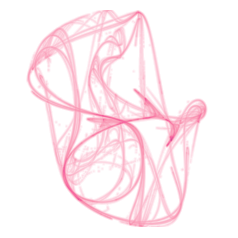

In [86]:
# custom colormaps
reds = plt.get_cmap('Reds')
#cmap = mcolors.LinearSegmentedColormap.from_list('custom', 
#                                                 [(0.,'w'), 
#                                                  (0.5,'#8A0707'),
#                                                  (1.,'k')]
#                                                )

rdpu = plt.get_cmap('RdPu')
cmap = mcolors.LinearSegmentedColormap.from_list('custom',
                                                 [(0.,'w'),
                                                  (0.4,rdpu(0.4)),
                                                  (0.5,rdpu(0.5)),
                                                  (1.0,rdpu(1.0))]
                                                )
#cmap = plt.get_cmap('RdPu')
save_fig(data, 'peterdejong8bit.png', cmap)

In [17]:
# custom colormaps
cmap = mcolors.LinearSegmentedColormap.from_list('janusz', [(0.,'k'), (0.5,'r'),(1.,'w')])


class PowerNorm(Normalize):
    """
    Normalize a given value to the ``[0, 1]`` interval with a power-law
    scaling. This will clip any negative data points to 0.
    """
    def __init__(self, gamma, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self, vmin, vmax, clip)
        self.gamma = gamma

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        gamma = self.gamma
        vmin, vmax = self.vmin, self.vmax
        if vmin > vmax:
            raise ValueError("minvalue must be less than or equal to maxvalue")
        elif vmin == vmax:
            result.fill(0)
        else:
            res_mask = result.data <1.0E-08
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                     mask=mask)
            resdat = result.data
            resdat -= vmin
            np.power(resdat, gamma, resdat)
            resdat /= (vmax - vmin) ** gamma

            result = np.ma.array(resdat, mask=result.mask, copy=False)
            result[res_mask] = -1.
        if is_scalar:
            result = result[0]
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        gamma = self.gamma
        vmin, vmax = self.vmin, self.vmax

        if cbook.iterable(value):
            val = np.ma.asarray(value)
            return np.ma.power(val, 1. / gamma) * (vmax - vmin) + vmin
        else:
            return pow(value, 1. / gamma) * (vmax - vmin) + vmin


    def autoscale(self, A):
        """
        Set *vmin*, *vmax* to min, max of *A*.
        """
        self.vmin = np.ma.min(A)
        if self.vmin < 0:
            self.vmin = 0
            warnings.warn("Power-law scaling on negative values is "
                          "ill-defined, clamping to 0.")
        self.vmax = np.ma.max(A)


    def autoscale_None(self, A):
        """autoscale only None-valued vmin or vmax."""
        A = np.asanyarray(A)
        if self.vmin is None and A.size:
            self.vmin = A.min()
            if self.vmin < 0:
                self.vmin = 0
                warnings.warn("Power-law scaling on negative values is "
                              "ill-defined, clamping to 0.")
        if self.vmax is None and A.size:
            self.vmax = A.max()
